# Autoencoder 25/11/2020

An autoencoder is a type of neural network which has a bottleneck layer in the center and attempts to reconstruct the input. The output of this is actually trying to approximate the input, so the reconstruction error is used as the cost function to minimise. We hopefully will end up with something that represents our input in low dimensions. Any feature of interest will have a higher re-construction cost. 

In [2]:
from tools import hop
import librosa 
import numpy as np
from sklearn.preprocessing import StandardScaler
import librosa.display

In [3]:
audio, sr = librosa.load("./data/youtube/wav/7_normal.wav")
X_ft = librosa.power_to_db(abs(librosa.feature.melspectrogram(audio,n_mels=30)))

librosa.display.specshow(X_ft[:,:2000],x_axis="time",y_axis='mel')

Frame duration is 0.05 s


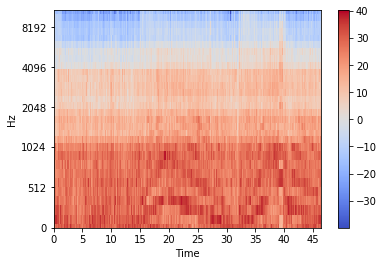

In [8]:
import matplotlib.pyplot as plt
audio_a,sr = librosa.load("./data/youtube/wav/7_switch_sound2.wav")
X_atk = librosa.power_to_db(abs(librosa.feature.melspectrogram(audio_a, n_mels=30, hop_length=1024)))
X_ft = librosa.power_to_db(abs(librosa.feature.melspectrogram(audio,n_mels=30, hop_length=1024)))
librosa.display.specshow(X_ft[:,:2000]+16,x_axis="time",y_axis='mel')
print("Frame duration is %.2f s" % (1024./sr))
plt.colorbar()

In [ ]:
segments = np.array(hop(X_ft,hop_size=2,window_size=8,flat=True))
x_atk = np.array(hop(X_atk, hop_size =2, window_size=8,flat=True))
print(x_atk.shape)
print(segments.shape)
#librosa.display.specshow(segments[20],x_axis="time",y_axis='hz')
print(segments[20].shape)
print("%d normal audio frames has been generated. The frames have shape %s" %(len(segments), str(segments[0].shape)) )

## Build the Autoencoder! 25/11/2020

build an autoencoder, will try a deeply connected autoencoder first, maybe this will work. need to consider how many neurons are needed for each layer. will use tensorflow to do this, but pytorch could be a good option as well. for training, just take nornmal audio data and slice into many small chunks. cannot do any validation yet, so just observe the output.

In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU') 


x_normal_train, x_normal_test = train_test_split(segments, test_size = 0.25)

print("Normal train count: %d" % len(x_normal_train))
print("Normal test count: %d"  % len(x_normal_test))
x_normal_train = np.array(x_normal_train)
x_normal_test = np.array(x_normal_test)
print(x_normal_train.shape)

2.3.1
Normal train count: 1571
Normal test count: 524
(1571, 240)


In [14]:
from sklearn import metrics 
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation,Conv2D

model = Sequential()
model.add(Dense(512, input_shape=(240,),activation='relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(240))
model.compile(loss = 'mean_squared_error', optimizer='adam')
model.summary()
model.fit(x_normal_train,x_normal_train,epochs = 200)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_43 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_44 (Dense)             (None, 40)                10280     
_________________________________________________________________
dense_45 (Dense)             (None, 256)               10496     
_________________________________________________________________
dense_46 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_47 (Dense)             (None, 240)               123120    
Total params: 530,200
Trainable params: 530,200
Non-trainable params: 0
________________________________________________

50/50 [==============================] - 0s 3ms/step - loss: 2.5099
Epoch 89/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4890
Epoch 90/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4645
Epoch 91/200
50/50 [==============================] - 0s 3ms/step - loss: 2.5315
Epoch 92/200
50/50 [==============================] - 0s 3ms/step - loss: 3.1749
Epoch 93/200
50/50 [==============================] - 0s 3ms/step - loss: 2.7409
Epoch 94/200
50/50 [==============================] - 0s 3ms/step - loss: 2.5098
Epoch 95/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4720
Epoch 96/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4790
Epoch 97/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4679
Epoch 98/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4701
Epoch 99/200
50/50 [==============================] - 0s 3ms/step - loss: 2.4794
Epoch 100/200
50/50 [====================

## 01/12/ 2020 

the simple fully connected autoencoder was built, it has 500k model parameters, which is a lot. this might not ve very good as it can very eaisly over fit. this is jsut a test on how autoencoders can work. trainign was very fast and it very quickly reached a poitn where the loss was no longer reducing. this indicates that the model has converged. 

In [39]:
pred = model.predict(x_normal_test)
pred1 = model.predict(x_atk)

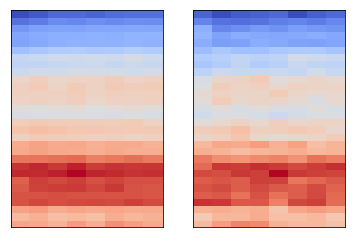

In [26]:
import matplotlib.pyplot as plt
i = 3
a= pred[i].reshape(30,8)
b = x_normal_test[i].reshape(30,8)
fig, axs = plt.subplots(1,2)
librosa.display.specshow(a,ax=axs[0])
librosa.display.specshow(b,ax=axs[1])


In [40]:
score1 = metrics.mean_absolute_error(pred1,x_atk)
score2 = metrics.mean_absolute_error(pred,x_normal_test)
print(score1,score2)

2.9830782 1.3812051


## 01/12/2020

THe autoencoder is able to reconstuct the input spectrogram. this fully connected version seems to have worked, but it is also noted that many features of the original spectrogram seem to be lost. also, there is not too much noise reduction going on. ideally the white and light orange parts should be made either dark blue or dark red, and features should be more visible. a deep convolutional auto encoder should be built, as they are more suitable for dealing with 2 dimensional data. 

### Build some of the 